## Notes
- [ ] condon features
- [ ] imputation for the missing nucleotide
- [x] distance matrix like to measure how close two sequence are
- [x] PCA on distance matrix, distances would be features
- [x] simple models
- [ ] generate data from phylogenetic tree
- [ ] high sample weights for false negatives
- [ ] similarly, give weights based on the variation frequencies of each loci
- [ ] **more accurate description of xy labels of graphs**

## Next Week
- [x] phylogentic tree
- [x] DendroPy
- [x] frequency of nucleotides

# Explore data

In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dendropy
from Bio import SeqIO, Phylo

%matplotlib inline
pd.options.display.precision = 3

In [159]:
# load responses-pseudo.csv - the result of antibiotic resistence of pseudomonas
# 122 * 2 (2 antibiotics)
resp = pd.read_csv('../data/responses-pseudo.csv', names=['id', 'lab-id', 'carb', 'toby'], skiprows=1)
resp.drop('lab-id', axis=1, inplace=True)

# load concatenated.fasta - the gene sequence of pseudomonas
# 122 * (483333 -> 261868)
src = SeqIO.parse('../data/concatenated.fasta', 'fasta')
data = [(record.id, record.seq._data) for record in src]
seq = pd.DataFrame(data=data, columns=['id', 'sequence'])

# merge DataFrames of two files into one DataFrame
records = pd.merge(seq, resp, on='id')

# calculate missing number and percentage of nucleotides of each sequence
seq_len = np.mean(records['sequence'].apply(len))
records['missing'] = records['sequence'].apply(lambda seq: Counter(seq)['-'])

records['missing_percentage'] = records['missing'] / seq_len * 100
records

,id,sequence,carb,toby,missing,missing_percentage
0,TA151,ATGAGTGATCTGCCAAGTCCGAAGAAACACAAGACCTCGAACTGGT...,True,False,31842,6.588
1,IC1,ATGAGTGATCTGCCAAGTCCGAAGAAACACAAGACCTCGAACTGGT...,False,False,46071,9.532
2,A237,ATGAGTGATCTGCCAAGTCCGAAGAAACACAAGACCTCGAACTGGT...,True,False,44514,9.210
3,5920,ATGAGTGATCTGCCAAGTCCGAAGAAACACAAGACCTCGAACTGGT...,NaN,NaN,49497,10.241
4,LiA96,ATGAGTGATCTGCCAAGTCCGAAGAAACACAAGACCTCGAACTGGT...,False,False,44067,9.117
...,...,...,...,...,...,...
117,JD318,----------------------------------------------...,False,False,77766,16.090
118,Jp238,----------------------------------------------...,False,False,43062,8.909
119,Jp1303,----------------------------------------------...,False,False,44151,9.135
120,JD304,----------------------------------------------...,False,False,75465,15.613


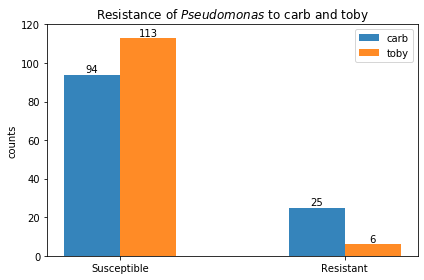

In [3]:
# show the skewness of the data set
def show_count(rects):
    '''Show the height of each bar in the bar chart'''
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                     xy=(rect.get_x() + rect.get_width()/2, height),
                     ha='center', va='bottom')

x = np.array([0, 1]) # False, True

counts_carb = records['carb'].value_counts()
carb = plt.bar(x=x-0.125, height=counts_carb, width=0.25, alpha=0.9, label='carb')
counts_toby = records['toby'].value_counts()
toby = plt.bar(x=x+0.125, height=counts_toby, width=0.25, alpha=0.9, label='toby')

show_count(carb)
show_count(toby)

plt.xticks(x, ['Susceptible', 'Resistant'])
plt.ylim((0, 120))
plt.ylabel('counts')
plt.title('Resistance of $Pseudomonas$ to carb and toby')

plt.tight_layout()
plt.legend()
plt.savefig('pseudo_skewness.png')
plt.show()

In [8]:
# calculate true/false percentage of two classes
counts = pd.DataFrame({'carb':counts_carb, 'toby':counts_toby})
counts.div(counts.sum() / 100)

,carb,toby
False,78.992,94.958
True,21.008,5.042


In [ ]:
# show the missingness of the sequence
data = records['missing_percentage']
n, bins, patches = plt.hist(data, bins=25, alpha=0.9)
mu, sigma = np.mean(data), np.std(data)

plt.grid()
plt.yticks(ticks=range(0, 21, 5))
plt.ylabel('counts')
plt.xlabel('percentage of missing nucleotides(%)')
plt.title('Distribution of percentage of missing nucleotides')
plt.text(12, 15, '$\mu={:.3}, \sigma={:.3}$'.format(mu, sigma))

plt.tight_layout()
plt.savefig('pseudo_missingness_1.png')
plt.show()

In [ ]:
highest_missing_percentage = np.max(records['missing_percentage'])
highest_missing_percentage

In [ ]:
# show the individual missingness of the sequence
plt.figure(figsize=(19.2, 4.8))
plt.scatter(range(122), records['missing_percentage'])

plt.xlim((-1, 122))
plt.ylim((0, 20))
plt.xticks(ticks=range(122), labels=records['id'].to_list(), rotation=90, fontsize=9)
plt.ylabel('percentage of missing nucleotides(%)')
plt.title('Individual percentage of missing nucleotides')
plt.grid(axis='y')
plt.savefig('pseudo_missingness_2.png')
plt.show()

In [12]:
# ratio of different nucleotides in total
c = Counter()
for seq in records['sequence']:
    c.update(Counter(seq))

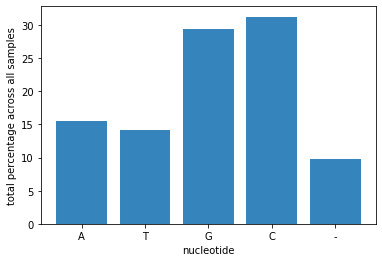

In [20]:
total = pd.Series(c)
total /= (total.sum() / 100)
plt.bar(x=total.index, height=total, alpha=0.9)

plt.xlabel('nucleotide')
plt.ylabel('total percentage across all samples')
plt.show()

# Group into condons

In [ ]:
# group genes in the sequence by three (into condons)
# and count different number of condons across all samples
condonify = lambda seq: [seq[i:i+3] for i in range(0, len(seq), 3)]
sequence_condonified = records['sequence'].apply(condonify)
c = Counter()
for condons in sequence_condonified:
    c.update(Counter(condons))

In [ ]:
len(c.keys())

In [ ]:
c.keys()

In [ ]:
# verify the result
sum(c.values()) * 3 / 122 == seq_len

In [ ]:
%time condon_df = pd.DataFrame(sequence_condonified.to_list())

## no imputation

In [ ]:
l = []
for i in range(condon_df.shape[1]):
    if condon_df.iloc[:, i].value_counts().size == 1:
        l.append(i)

In [ ]:
condon_df_variant = condon_df.drop(columns=l)
condon_df_variant.shape

## naive imputation

In [ ]:
def impute(condons):
    '''replace --- with the most frequent condon at this locus'''
    counts = condons.value_counts()
    if '---' in counts.index:
        return condons.where(condons!='---', counts.idxmax())
    return condons

In [ ]:
%time condon_df_impute = condon_df.apply(impute)

In [ ]:
l_impute = []
for i in range(condon_df_impute.shape[1]):
    if condon_df_impute.iloc[:, i].value_counts().size == 1:
        l_impute.append(i)

In [ ]:
condon_df_impute_variant = condon_df_impute.drop(columns=l_impute)
condon_df_impute_variant.shape

In [ ]:
c = []
for col in condon_df_impute_variant.columns:
    c.append(condon_df_impute_variant[col].value_counts().size)
condon_counts = np.bincount(c)

In [ ]:
# number of different condons at each loci
plt.bar(np.arange(condon_counts.size), condon_counts)
plt.xlim((0, 15))
plt.xlabel('different condons at a particular locus')
plt.ylabel('counts of different condons')

In [ ]:
# condon_df_impute_variant['missing'] = condon_df_impute_variant.agg()
missing = []
count_missing = lambda series: Counter(''.join(series))['-']
for row in range(condon_df_impute_variant.shape[0]):
    missing.append(count_missing(condon_df_impute_variant.iloc[row]))

In [ ]:
missing[:5]

In [ ]:
len(''.join(condon_df_impute_variant.iloc[1])), count_missing(''.join(condon_df_impute_variant.iloc[1]))

In [ ]:
seq_len_variant = condon_df_impute_variant.columns.size * 3
missing_percent = np.array(missing) / seq_len_variant * 100
plt.hist(missing_percent, bins=25)

# Distance matrix & Phylogenetic tree

In [ ]:
def diff(seq1, seq2):
    '''Count the number of different loci between two sequences'''
    diff_count = 0
    for n1, n2 in zip(seq1, seq2):
        if n1 != n2:
            diff_count += 1
    return diff_count

In [ ]:
# build the distance matrix
dist_mat = np.zeros((records.shape[0], records.shape[0]), dtype='i4')
for i in range(records.shape[0]):
    for j in range(i, records.shape[0]):
        d = diff(records['sequence'][i], records['sequence'][j])
        dist_mat[i, j] = d
        dist_mat[j, i] = d

In [ ]:
dist_mat = pd.DataFrame(dist_mat, index=records['id'], columns=records['id'])
dist_mat[dist_mat==0] = np.inf
dist_mat.to_csv('../data/pseudo_dist_mat.csv')

In [204]:
dist_mat = pd.read_csv('../data/pseudo_dist_mat.csv', index_col='id')
dist_mat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, TA151 to LiA131
Columns: 122 entries, TA151 to LiA131
dtypes: float64(122)
memory usage: 117.2+ KB


## testing

In [ ]:
# test data for UPGMA
data = np.array([[0 , 9 , 2 , 4 , 9 , 10],
                 [9 , 0 , 9 , 6 , 2 , 10],
                 [2 , 9 , 0 , 5 , 9 , 10],
                 [4 , 6 , 5 , 0 , 6 , 10],
                 [9 , 2 , 9 , 6 , 0 , 10],
                 [10, 10, 10, 10, 10,  0]], dtype='i4')
test = pd.DataFrame(data, index=list('ABCDEF'), columns=list('ABCDEF'))
test[test==0] = np.inf
test

In [ ]:
mask = test == test.min().min()
mask

In [ ]:
row = mask.any(axis=1)
pos = test[row].idxmin(axis=1)
pos

In [ ]:
a = pos.index[0]
b = pos[0]
result = (test.loc[a] + test.loc[b]) / 2
test.loc[a] = result
test.loc[:, a] = result
temp = test.drop(b, axis=0).drop(b, axis=1)
temp.rename(mapper=lambda s: s if s != a else '({}/{})'.format(a, b), axis=0, inplace=True)
temp.rename(mapper=lambda s: s if s != a else '({}/{})'.format(a, b), axis=1, inplace=True)
temp

In [ ]:
a = pos.index[1]
b = pos[1]
result = (test.loc[a] + test.loc[b]) / 2
test.loc[a] = result
test.loc[:, a] = result
test.drop(b, axis=0).drop(b, axis=1)

In [ ]:
# test data for UPGMA
data = np.array([[0 , 9 , 2 , 4 , 9 , 10],
                 [9 , 0 , 9 , 6 , 2 , 10],
                 [2 , 9 , 0 , 5 , 9 , 10],
                 [4 , 6 , 5 , 0 , 6 , 10],
                 [9 , 2 , 9 , 6 , 0 , 10],
                 [10, 10, 10, 10, 10,  0]], dtype='i4')

test = pd.DataFrame(data, index=list('ABCDEF'), columns=list('ABCDEF'))
test[test==0] = np.inf

while test.size > 1:
    mask = test == test.min().min()   # where is the minimum
    row = mask.any(axis=1)            # which row
    pos = test[row].idxmin(axis=1)    # which column
    for i in range(0, pos.size//2):
        a = pos.index[i]
        b = pos[i]
        # combine the row and column of one with the other
        result = (test.loc[a] + test.loc[b]) / 2
        test.loc[a] = result
        test.loc[:, a] = result
        # drop row and coulmn of the other
        test = test.drop(b, axis=0).drop(b, axis=1)
        # rename index and column name of the combined sample
        test.rename(mapper=lambda s: s if s != a else '({},{})'.format(a, b), axis=0, inplace=True)
        test.rename(mapper=lambda s: s if s != a else '({},{})'.format(a, b), axis=1, inplace=True)
test.index[0]

In [ ]:
# test data for UPGMA
data = np.array([[0 , 9 , 2 , 4 , 9 , 10],
                 [9 , 0 , 9 , 6 , 2 , 10],
                 [2 , 9 , 0 , 5 , 9 , 10],
                 [4 , 6 , 5 , 0 , 6 , 10],
                 [9 , 2 , 9 , 6 , 0 , 10],
                 [10, 10, 10, 10, 10,  0]], dtype='i4')

test = pd.DataFrame(data, index=list('ABCDEF'), columns=list('ABCDEF'))
test[test==0] = np.inf
tree = upgma(test)
tree

In [ ]:
t = dendropy.Tree.get(data=tree, schema='newick')
print(t.as_ascii_plot())

## testing end

In [202]:
def upgma(df, copy=True):
    '''Build a phylogenetic tree (in newick format) using UPGMA based on a distance matrix'''
    if copy:
        df = df.copy()
    while df.size > 1:
        mask = (df == df.min().min())     # where is the minimum
        row = mask.any(axis=1)            # which row
        pos = df[row].idxmin(axis=1)      # which column
        for i in range(0, pos.size//2):
            a = pos.index[i]
            b = pos[i]
            # combine the row and column of one with the other
            result = (df.loc[a] + df.loc[b]) / 2
            df.loc[a] = result
            df.loc[:, a] = result
            # drop row and coulmn of the other
            df = df.drop(b, axis=0).drop(b, axis=1)
            # rename index and column name of the combined sample
            df.rename(mapper=lambda s: s if s != a else '({},{})'.format(a, b), axis=0, inplace=True)
            df.rename(mapper=lambda s: s if s != a else '({},{})'.format(a, b), axis=1, inplace=True)
    return df.index[0]+';'

In [205]:
# create the tree
%time tree_str = upgma(dist_mat)
with open('../data/pseudo_tree.dnd', 'w') as dnd:
    dnd.write(tree_str)
tree_str

CPU times: user 2.04 s, sys: 4.52 ms, total: 2.05 s
Wall time: 2.08 s


'(((((((((TA151,(((Jp222,(Bo559,W15Apr4)),Cotonu1),LiA179)),((((Lw1047,CPHL2000),(((LiA18,Jp241),A17),Aa249)),LiA145),(((A15,A9),Tu863),(Tu61,SWPA15J_NSWPA15a)))),((ATCC27853,((LiA50,(A22,(W15Aug23,Us411))),(M72,((A11,A13),(5BR2,CPHL10299))))),PhDW6)),(((((IC1,((CPHL950,Mi159),W5Aug16)),Pae85),((ESP06B,Br993),(Co380791,Co398373))),(((((A237,Pae113),(W15Okt31,Jp245)),(((C3128,PT31M),W5Aug28),(C5311,JD303))),LiA161),(A19,((((Pae110,Pae100),Pae102),CPHL8203),CPHL5083)))),(((((LiA96,LiA91),LiA131),PMM38),Mex2),((W15Dec3,CND03),Jp1303)))),((((((5920,(PHLS08959,W15Dec4)),(((A10,CPHL6749),Jp238),Pae160)),(Lo049,(CPHL1999,CPHL8058))),CPHL10701),(LiA70,Br670)),(((((Jp1170,Jp1200),(Jp1155,Jp1206)),TuD199),Jp224),LMG2107))),((CPHL10662,(Jp100,Jp97)),(J80UH1OS1,LiA133))),((((CN573_PSE143,(((Jp54,Jp60),J9UH1F),(W15Dec14,LiA63))),(PAO1,IDEXXCanine4)),LiA19),IDEXXCanine8)),((((JD312,JD317),(((((((JD310,JD326),JD329),JD315),JD322),JD335),JD324),JD304)),((((((JD332,JD323),JD314),(JD328,(JD316,(JD333,JD

In [206]:
with open('../data/pseudo_tree.dnd', 'r') as dnd:
    tree_str = dnd.read()

In [207]:
# visualize tree with dendropy
tree = dendropy.Tree.get(data=tree_str, schema='newick')
print(tree.as_ascii_plot())

                                       /---------------------- TA151           
                                       |                                       
                                       |             /-------- Jp222           
                               /-------+        /----+                         
                               |       |        |    |   /---- Bo559           
                               |       |    /---+    \---+                     
                               |       |    |   |        \---- W15Apr4         
                               |       \----+   |                              
                               |            |   \------------- Cotonu1         
                               |            |                                  
                               |            \----------------- LiA179          
                               |                                               
                               |        

In [208]:
# format the ascii tree with labels
tree_ascii = tree.as_ascii_plot()
for i, record in records.iterrows():
    l = len(record['id'])
    if l < 8:
        indent = '\t\t\t'
    elif l < 13:
        indent = '\t\t'
    else:
        indent = '\t'
    tree_ascii = tree_ascii.replace(record['id'].replace('_', ' '),
                                    '{id__}:{indent}{carb}/{toby}'.format(
                                        id__=record['id'].lower(), # lower case to avoid something wrong
                                        indent=indent,carb=record['carb'],toby=record['toby']),
                                    1)
print(tree_ascii)

                                       /---------------------- ta151:			True/False           
                                       |                                       
                                       |             /-------- jp222:			False/False           
                               /-------+        /----+                         
                               |       |        |    |   /---- bo559:			False/False           
                               |       |    /---+    \---+                     
                               |       |    |   |        \---- w15apr4:			False/False         
                               |       \----+   |                              
                               |            |   \------------- cotonu1:			False/False         
                               |            |                                  
                               |            \----------------- lia179:			False/False          
                               

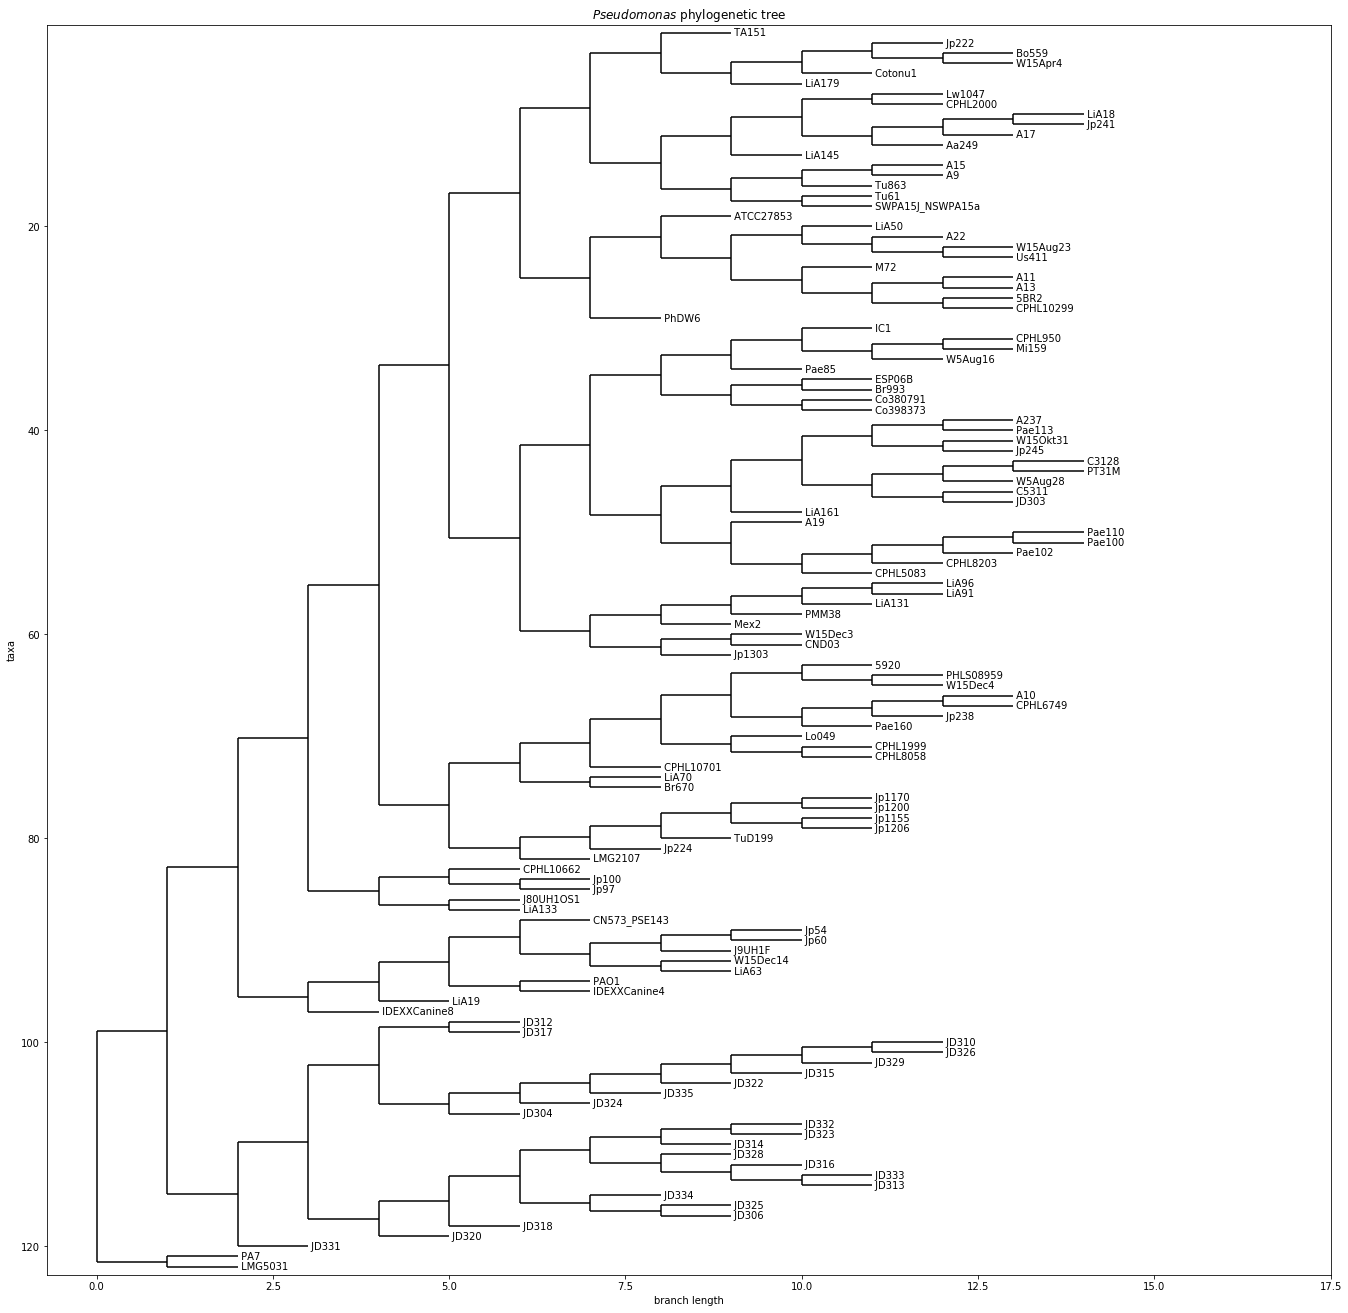

In [134]:
# visualize tree with biopython and matplotlib
tree = Phylo.read('../data/pseudo_tree.dnd', format='newick')
plt.figure(figsize=(23, 23))
plt.title('$Pseudomonas$ phylogenetic tree')
Phylo.draw(tree, axes=plt.gca())

# Dimensionality reduction on distance matrix

In [50]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [44]:
dist_mat = pd.read_csv('../data/pseudo_dist_mat.csv', index_col='id')
dist_mat[dist_mat==np.inf] = 0

In [45]:
scaler = StandardScaler()
dist_mat_scaled = scaler.fit_transform(dist_mat)

In [50]:
pca = PCA(n_components=2)
dist_mat_pca = pca.fit_transform(dist_mat_scaled)

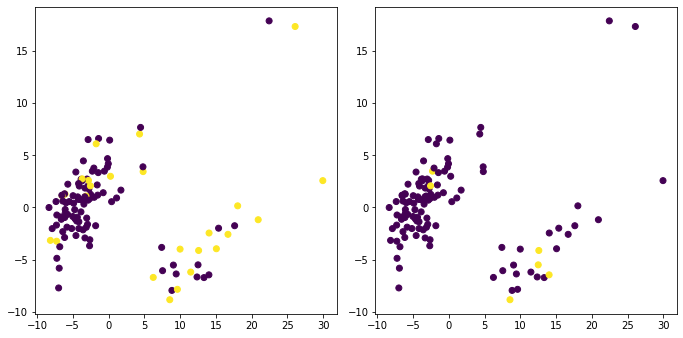

In [64]:
plt.figure(figsize=(9.6, 4.8))
plt.subplot('121')
plt.scatter(dist_mat_pca[:, 0], dist_mat_pca[:, 1], c=records['carb'])
plt.subplot('122')
plt.scatter(dist_mat_pca[:, 0], dist_mat_pca[:, 1], c=records['toby'])

plt.tight_layout()
plt.show()

In [67]:
tsne = TSNE(n_components=2)
dist_mat_tsne = tsne.fit_transform(dist_mat_scaled)

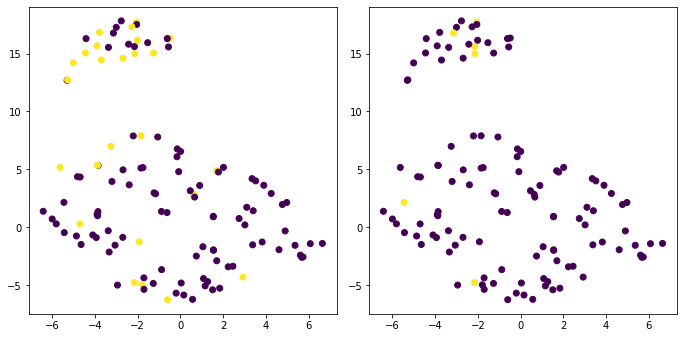

In [68]:
plt.figure(figsize=(9.6, 4.8))
plt.subplot('121')
plt.scatter(dist_mat_tsne[:, 0], dist_mat_tsne[:, 1], c=records['carb'])
plt.subplot('122')
plt.scatter(dist_mat_tsne[:, 0], dist_mat_tsne[:, 1], c=records['toby'])

plt.tight_layout()
plt.show()

# Experiment

## remove redundant feature

In [95]:
records.dropna(inplace=True)

In [96]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()

In [97]:
encoding = records['sequence'].apply(transformation)

In [98]:
encoding = pd.DataFrame(encoding.to_dict()).transpose().to_numpy()

In [99]:
encoding.dump('../data/pseudo_encoding.dat')

In [100]:
%time encoding_trans = selector.fit_transform(encoding)

CPU times: user 546 ms, sys: 124 ms, total: 670 ms
Wall time: 680 ms


In [101]:
encoding_trans.shape

(119, 261677)

## encoding

In [102]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto', handle_unknown='ignore')

In [103]:
encoding_seq = encoder.fit_transform(encoding_trans)

In [104]:
encoding_seq

<119x592901 sparse matrix of type '<class 'numpy.float64'>'
	with 31139563 stored elements in Compressed Sparse Row format>

In [105]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
encoding_seq_svd = svd.fit_transform(encoding_seq)

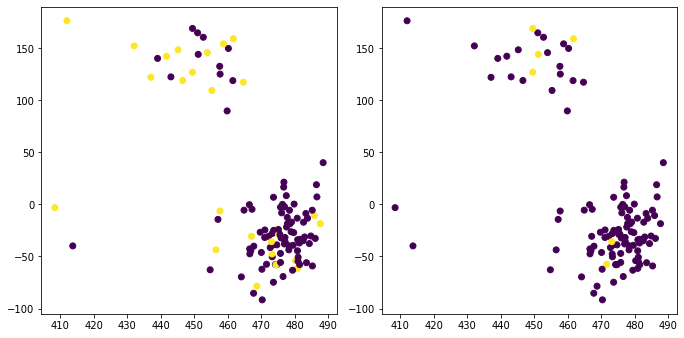

In [106]:
plt.figure(figsize=(9.6, 4.8))
plt.subplot('121')
plt.scatter(encoding_seq_svd[:, 0], encoding_seq_svd[:, 1], c=records['carb'])
plt.subplot('122')
plt.scatter(encoding_seq_svd[:, 0], encoding_seq_svd[:, 1], c=records['toby'])

plt.tight_layout()
plt.show()

# Training

In [119]:
from sklearn.model_selection import train_test_split

In [118]:
X  = encoding_seq.todense()
y1, y2 = records['carb'].astype('bool'), records['toby'].astype('bool')

In [121]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, stratify=y2)

In [110]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, )

In [122]:
rf_clf.fit(X1_train, y1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [124]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y1_test, rf_clf.predict(X1_t))

array([[22,  2],
       [ 4,  2]])

In [126]:
rf_clf.fit(X2_train, y2_train)
confusion_matrix(y2_test, rf_clf.predict(X2_test))

array([[28,  0],
       [ 2,  0]])

In [129]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs')

In [130]:
lr.fit(X1_train, y1_train)
confusion_matrix(y1_test, lr.predict(X1_test))

array([[23,  1],
       [ 5,  1]])

In [131]:
lr.fit(X2_train, y2_train)
confusion_matrix(y2_test, lr.predict(X2_test))

array([[28,  0],
       [ 2,  0]])